In [126]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# 被験者ID
subject_id = "001"
# 実験番号
experiment_id = "001"

# IDT法のパラメータ
DISPERSION_THRESHOLD = 1.0  # deg
DURATION_THRESHOLD_MS = 100  # ms

eye_df = pd.read_csv(f"exported_csv/eye_df_id{subject_id}-{experiment_id}.csv")
sampling_df = pd.read_csv(f"exported_csv/sampling_df_id{subject_id}-{experiment_id}.csv")

In [127]:

# モニターサイズ(物理)
monitor_width_cm = 47.6
monitor_height_cm = 26.8
# モニター解像度(px)
monitor_resolution_px = (1920, 1080)
# 視距離(cm)
viewer_distance_cm = 70.0

# cm/pxの変換係数
cm_per_pixel_x = monitor_width_cm / monitor_resolution_px[0]
cm_per_pixel_y = monitor_height_cm / monitor_resolution_px[1]

# ディスプレイ中心を(0, 0)とするための変換
eye_df["gx_centered"] = eye_df["gx"] - 0.5
eye_df["gy_centered"] = eye_df["gy"] - 0.5

# 中心(0,0)での物理距離変換
eye_df["x_cm"] = eye_df["gx_centered"] * monitor_resolution_px[0] * cm_per_pixel_x
eye_df["y_cm"] = eye_df["gy_centered"] * monitor_resolution_px[1] * cm_per_pixel_y

# 視野角の計算
eye_df["x_deg"] = np.degrees(np.arctan2(eye_df["x_cm"], viewer_distance_cm))
eye_df["y_deg"] = np.degrees(np.arctan2(eye_df["y_cm"], viewer_distance_cm))

# データの有効性
eye_df["is_valid"] = eye_df["validity_sum"] > 1

print(eye_df.head())


         gx        gy     epoch_sec        hhmmss  validity_sum  trial  \
0       NaN       NaN  1.732521e+09  16:49:03.491             0     -1   
1  0.476050  0.816155  1.732521e+09  16:49:03.506             2     -1   
2  0.490610  0.818481  1.732521e+09  16:49:03.522             2     -1   
3  0.520527  0.754540  1.732521e+09  16:49:03.538             2     -1   
4  0.507679  0.780874  1.732521e+09  16:49:03.538             2     -1   

   gx_centered  gy_centered      x_cm      y_cm     x_deg     y_deg  is_valid  
0          NaN          NaN       NaN       NaN       NaN       NaN     False  
1    -0.023950     0.316155 -1.140020  8.472954 -0.933037  6.901632      True  
2    -0.009390     0.318481 -0.446964  8.535291 -0.365840  6.951913      True  
3     0.020527     0.254540  0.977085  6.821672  0.799703  5.566039      True  
4     0.007679     0.280874  0.365520  7.527423  0.299180  6.137694      True  


In [128]:
def interpolate_missing(df, time_col="epoch_sec", max_gap_ms=100):
    df= df.copy()
    df["valid"]= df["is_valid"]
    df["interp_x"]= np.nan
    df["interp_y"]= np.nan

    # 有効データを代入
    df.loc[df["valid"], "interp_x"] = df.loc[df["valid"], "x_deg"]
    df.loc[df["valid"], "interp_y"] = df.loc[df["valid"], "y_deg"]
    
    # 内部のみ線形補完
    df["interp_x"] = df["interp_x"].interpolate(limit_area="inside")
    df["interp_y"] = df["interp_y"].interpolate(limit_area="inside")
    
    # 無効区間の連続ブロックを取得
    invalid_mask = ~df["valid"]
    group_id = (invalid_mask != invalid_mask.shift()).cumsum()
    invalid_blocks = df[invalid_mask].groupby(group_id)

    for _, block in invalid_blocks:
        if len(block) == 0:
            continue
        t_start = block[time_col].iloc[0]
        t_end = block[time_col].iloc[-1]
        duration_ms = (t_end - t_start) * 1000
        if duration_ms > max_gap_ms:
            # 100ms超えたら補完結果をNaNに戻す
            df.loc[block.index, ["interp_x", "interp_y"]] = np.nan
    

    return df
    
    

In [129]:
def apply_gaussian_filter_by_block(df, col_x="x_deg", col_y="y_deg", sigma=1.0):
    df = df.copy()
    df["valid"]= df["is_valid"]
    df["filtered_x"] = np.nan
    df["filtered_y"] = np.nan

    # 有効なデータ（NaNでない）だけを連続ブロックとして抽出
    valid_mask = df[col_x].notna() & df[col_y].notna()
    block_id = (valid_mask != valid_mask.shift()).cumsum()
    blocks = df[valid_mask].groupby(block_id)

    for _, block in blocks:
        idx = block.index
        smoothed_x = gaussian_filter1d(block[col_x], sigma=sigma)
        smoothed_y = gaussian_filter1d(block[col_y], sigma=sigma)
        df.loc[idx, "filtered_x"] = smoothed_x
        df.loc[idx, "filtered_y"] = smoothed_y

    return df


In [130]:
def detect_fixations_idt(df, dispersion_threshold=DISPERSION_THRESHOLD , duration_threshold_ms=DURATION_THRESHOLD_MS):
    fixations = []
    timestamps = df["epoch_sec"].to_numpy()
    xs = df["filtered_x"].to_numpy()
    ys = df["filtered_y"].to_numpy()
    
    i=0
    while i < len(df):
        if np.isnan(xs[i]) or np.isnan(ys[i]):
            i += 1
            continue
        
        window = [(xs[i], ys[i])]
        t_start = timestamps[i]
        j = i + 1
        
        while j < len(df):
            if np.isnan(xs[j]) or np.isnan(ys[j]):
                break
            window.append((xs[j], ys[j]))
            t_end = timestamps[j]
            duration = (t_end - t_start) * 1000
            
            x_vals, y_vals = zip(*window)
            x_center = np.mean(x_vals)
            y_center = np.mean(y_vals)
            
            distances = np.sqrt((np.array(x_vals) - x_center) ** 2 + (np.array(y_vals) - y_center) ** 2)
            
            if np.max(distances) > dispersion_threshold:
                break
            if duration >= duration_threshold_ms:
                fixations.append({
                    "start_time": t_start,
                    "end_time": t_end,
                    "duration_ms": duration,
                    "x_mean_deg": np.mean(x_vals),
                    "y_mean_deg": np.mean(y_vals),
                })
            j += 1
        i = j
    return pd.DataFrame(fixations)
    

In [131]:
def deg_to_px(x_deg, y_deg):
    x_cm = np.tan(np.radians(x_deg)) * viewer_distance_cm
    y_cm = np.tan(np.radians(y_deg)) * viewer_distance_cm
    
    x_px = (x_cm / cm_per_pixel_x) + (monitor_resolution_px[0] / 2)
    y_px = (y_cm / cm_per_pixel_y) + (monitor_resolution_px[1] / 2)
    
    return x_px, y_px
    

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09   109.999895   -2.426722   -0.013318    0.0   
1  1.732521e+09  1.732521e+09   125.999928   -2.420995   -0.033364    0.0   
2  1.732521e+09  1.732521e+09   141.999960   -2.406845   -0.048951    0.0   
3  1.732521e+09  1.732521e+09   157.999992   -2.381662   -0.059840    0.0   
4  1.732521e+09  1.732521e+09   172.999859   -2.341231   -0.065692    0.0   

         x_px        y_px  
0  840.339856  539.344324  
1  840.622568  538.357355  
2  841.321159  537.589969  
3  842.564304  537.053847  
4  844.560150  536.765711  
999


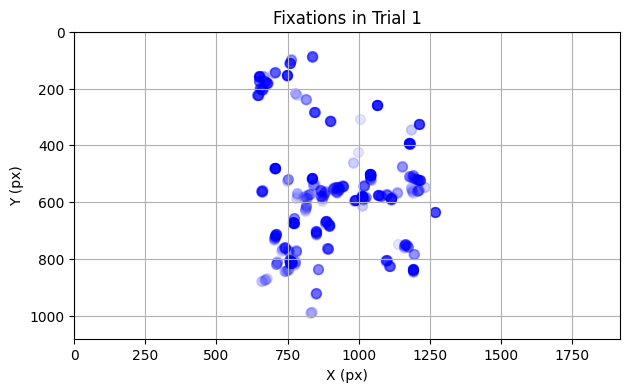

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09   110.999823   -0.159124    0.197383    1.0   
1  1.732521e+09  1.732521e+09   126.999855   -0.167530    0.194890    1.0   
2  1.732521e+09  1.732521e+09   142.999887   -0.169346    0.195941    1.0   
3  1.732521e+09  1.732521e+09   158.999920   -0.167540    0.194898    1.0   
4  1.732521e+09  1.732521e+09   174.999952   -0.164074    0.190006    1.0   

         x_px        y_px  
0  952.158373  549.717962  
1  951.744101  549.595255  
2  951.654640  549.647000  
3  951.743633  549.595631  
4  951.914441  549.354772  
1009


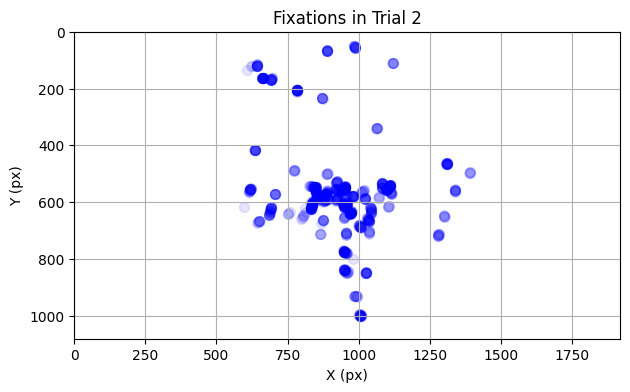

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09   111.999989   -0.167537    0.575719    2.0   
1  1.732521e+09  1.732521e+09   128.000021   -0.123797    0.643203    2.0   
2  1.732521e+09  1.732521e+09   111.000061   -6.285117    1.521129    2.0   
3  1.732521e+09  1.732521e+09   126.000166   -6.244324    1.493456    2.0   
4  1.732521e+09  1.732521e+09   111.000061   -1.379220    0.955338    2.0   

         x_px        y_px  
0  951.743780  568.345846  
1  953.899308  571.668730  
2  649.021810  614.908742  
3  651.056316  613.545339  
4  892.019074  587.039398  
805


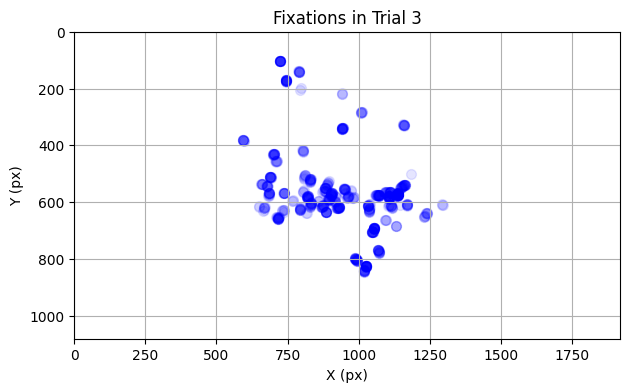

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09   111.000061   -0.737845    0.310884    3.0   
1  1.732521e+09  1.732521e+09   127.000093   -0.748218    0.329462    3.0   
2  1.732521e+09  1.732521e+09   143.000126   -0.758384    0.339727    3.0   
3  1.732521e+09  1.732521e+09   143.000126   -0.764932    0.341013    3.0   
4  1.732521e+09  1.732521e+09   143.000126   -0.761948    0.336210    3.0   

         x_px        y_px  
0  923.637073  555.306193  
1  923.125792  556.220902  
2  922.624758  556.726276  
3  922.301980  556.789620  
4  922.449066  556.553115  
1018


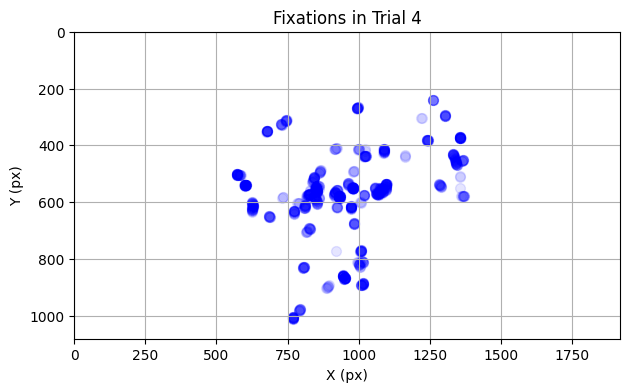

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09   111.999989   -0.201349    0.285922    4.0   
1  1.732521e+09  1.732521e+09   128.000021   -0.195643    0.317861    4.0   
2  1.732521e+09  1.732521e+09   144.000053   -0.190490    0.359523    4.0   
3  1.732521e+09  1.732521e+09   160.000086   -0.187183    0.411684    4.0   
4  1.732521e+09  1.732521e+09   175.999880   -0.183921    0.472157    4.0   

         x_px        y_px  
0  950.077516  554.077182  
1  950.358693  555.649698  
2  950.612636  557.700963  
3  950.775622  560.269183  
4  950.936347  563.246649  
935


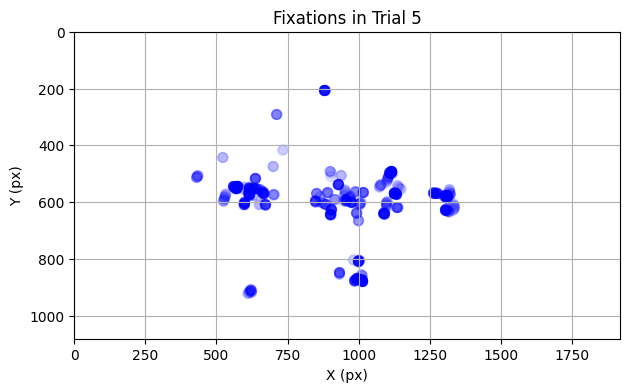

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09   111.999989   -2.661426    1.139433    5.0   
1  1.732521e+09  1.732521e+09   127.000093   -2.672173    1.145640    5.0   
2  1.732521e+09  1.732521e+09   143.000126   -2.679560    1.146798    5.0   
3  1.732521e+09  1.732521e+09   158.999920   -2.688372    1.148615    5.0   
4  1.732521e+09  1.732521e+09   174.999952   -2.700357    1.154416    5.0   

         x_px        y_px  
0  828.750843  596.106148  
1  828.220071  596.411862  
2  827.855213  596.468921  
3  827.420032  596.558367  
4  826.828101  596.844108  
857


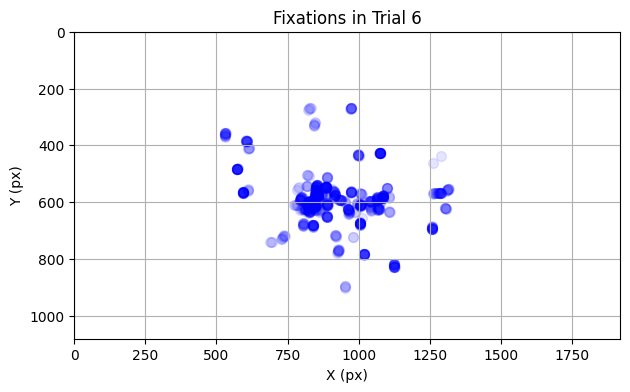

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732521e+09  1.732521e+09   111.999989   -0.560382    1.611440    6.0   
1  1.732521e+09  1.732521e+09   128.000021   -0.551445    1.517529    6.0   
2  1.732521e+09  1.732521e+09   144.000053   -0.547134    1.433210    6.0   
3  1.732521e+09  1.732521e+09   111.999989   -0.553561    0.540722    6.0   
4  1.732521e+09  1.732521e+09   128.000021   -0.537029    0.531753    6.0   

         x_px        y_px  
0  932.383537  619.358433  
1  932.824025  614.731366  
2  933.036481  610.577267  
3  932.719726  566.622638  
4  933.534502  566.181023  
824


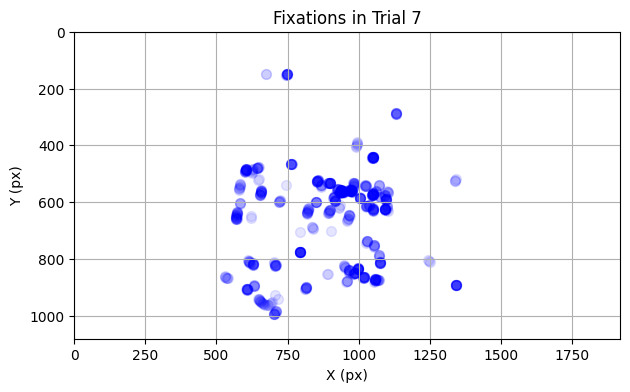

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
     start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0  1.732522e+09  1.732522e+09   110.000134   -0.773915    0.330618    7.0   
1  1.732522e+09  1.732522e+09   126.000166   -0.764965    0.344321    7.0   
2  1.732522e+09  1.732522e+09   141.000032   -0.761595    0.357493    7.0   
3  1.732522e+09  1.732522e+09   156.000137   -0.760807    0.372757    7.0   
4  1.732522e+09  1.732522e+09   172.000170   -0.760430    0.394340    7.0   

         x_px        y_px  
0  921.859231  556.277792  
1  922.300363  556.952465  
2  922.466481  557.601023  
3  922.505337  558.352556  
4  922.523910  559.415230  
776


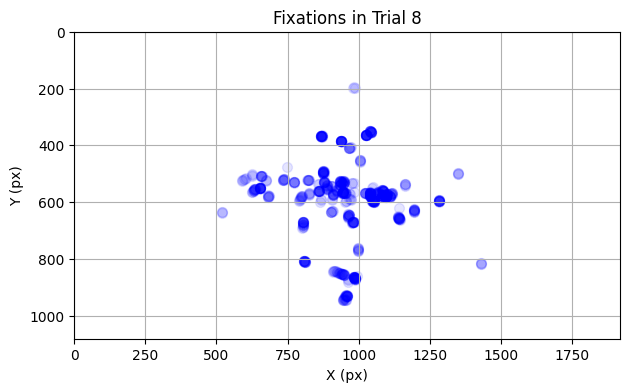

In [ ]:
# === トライアルごとの処理 + プロット ===
all_fixations = []

for _, row in sampling_df.iterrows():
    t_start = row["start_sec"]
    t_end = row["end_sec"]
    trial_num = row["trial"]

    df_trial = eye_df[(eye_df["epoch_sec"] >= t_start) & (eye_df["epoch_sec"] <= t_end)]
    df_interp = interpolate_missing(df_trial)
    df_filtered= apply_gaussian_filter_by_block(df_interp)
    fix_df = detect_fixations_idt(df_filtered, DISPERSION_THRESHOLD, DURATION_THRESHOLD_MS)
    
    if fix_df.empty:
        print(f"Trial {trial_num}: No fixations detected.")
        continue
    
    fix_df["trial"] = trial_num

    print("**************************************")
    
    # 座標変換
    fix_df["x_px"], fix_df["y_px"] = deg_to_px(fix_df["x_mean_deg"], fix_df["y_mean_deg"])

    all_fixations.append(fix_df)
    
    print(fix_df)
    print(len(fix_df))

    # プロット
    plt.scatter(fix_df["x_px"], fix_df["y_px"], alpha=0.1,c='blue', s=50)
    plt.axis("scaled")
    plt.xlim(0, monitor_resolution_px[0])
    plt.ylim(monitor_resolution_px[1], 0)  # y軸を上向きに
    plt.title(f"Fixations in Trial {int(trial_num+1)}")
    plt.xlabel("X (px)")
    plt.ylabel("Y (px)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    

In [133]:
# new1_df=interpolate_missing(eye_df)
# # print(new1_df.head())
# new2_df=apply_gaussian_filter_by_block(new1_df)
# new3_df=detect_fixations_idt(new2_df)
# deg_to_px(new3_df["x_mean_deg"], new3_df["y_mean_deg"])